# Load Dependencies

In [1]:
# load dependencies'
import concurrent.futures
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import osmnx as ox
import networkx as nx
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from urllib.parse import urljoin
from shapely.geometry import Point, LineString, Polygon
import pyproj 
import mm_utils
from FIS2 import FIS2
from datetime import datetime

In [86]:
def get_bearing(point1, point2):
    # this code calculate the bearing of any given pair of longitude, latitude  
    geodesic = pyproj.Geod(ellps='WGS84')
    fwd_azimuth,back_azimuth,distance = geodesic.inv(point1[0], point1[1], point2[0], point2[1])
    return fwd_azimuth

def edge_bearing(edge):
    # this function calculate the bearing from the starting and ending node of each road segment
    bearing = get_bearing(edge[0], edge[len(edge) - 1])
    return(bearing)
    
def conv_angle(angle):
    # this function convert angle from -pi,pi to 0,2*pi
    if angle < 0 :
        angle = angle + 360
    return(angle)

def conc(a):
    #function to convert list or integer in osmid into a unique string id 
    if type(a) is int:
        return str(a)
    ans = ",".join(map(str, a))
    return ans

def err_polygon(curr_loc, err_size):
    # function that output shapely polygon for point error bound
    x = curr_loc['geometry'].iloc[0].x
    y = curr_loc['geometry'].iloc[0].y
    
    err_coord = [[x - err_size, y + err_size], 
                 [x + err_size, y + err_size],
                 [x + err_size, y - err_size],
                 [x - err_size, y - err_size]]

    poly_coord = Polygon(err_coord)
    # #print(ply_coord)
    df = {'Attribute' : ['name1'], 'geometry':poly_coord}

    #projected to UTM 31 
    err_poly = gpd.GeoDataFrame(df, geometry = 'geometry', crs = "EPSG:32631")
    
    return err_poly

def point_matching(curr_loc, curr_edge):
    # matched position to the current edge 
    # input need to be panda series
    # curr loc need attribute geometry point
    # curr_edge need attribute 'geometry' lines
    # output a point that matched to the current edge
    dist = curr_edge['geometry'].project(curr_loc['geometry']).iloc[0]
    matched_point = list(curr_edge['geometry'].interpolate(dist).coords)
    matched_point = gpd.GeoDataFrame(geometry=gpd.points_from_xy([matched_point[0][0]], [matched_point[0][1]]), crs="EPSG:32631")
    return matched_point

def check_connect(link):
    # this function check connectivity of candidate link with the current edge
    # needed to convert key to column and the previous end node saved in the dataframe
    # 1 if its connect 0 if elsewhere
    if (link['u'] == link['prev_end_node']):
        a = 1
    else : 
        a = 0
    return a

In [87]:
gdf_utm = pd.read_pickle('gdf_utm.pkl')
edges_utm = pd.read_pickle('edges_utm.pkl')
nodes_utm = pd.read_pickle('nodes_utm.pkl')
curr_edge = pd.read_pickle('current_edge.pkl')

# for debugging purposes start at iteration point 14 
point_index = 14
# this is for debugging purposes, true 
prev_loc = gdf_utm.iloc[point_index-1].to_frame().T
last_matched = point_matching(prev_loc, curr_edge.iloc[0])


# current location 
curr_loc = gdf_utm.iloc[[point_index]]

# find longitude and latitude for last matched data
last_matched['lon_lat'] = last_matched.to_crs({'init': 'epsg:4326'})

C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [5]:
curr_edge

,,,osmid,lanes,ref,name,highway,maxspeed,oneway,reversed,length,geometry,width,access,lon_lat,str_id
u,v,key,,,,,,,,,,,,,,
53200191,135535395,0,"[673214248, 234046511]",3,L 793,Wolbecker Straße,secondary,50,False,True,54.889,"LINESTRING (819585.705 5766245.100, 819590.522...",NaN,NaN,"LINESTRING (7.65181 51.95487, 7.65188 51.95486...","673214248,234046511"
135535395,53200191,0,"[673214248, 234046511]",3,L 793,Wolbecker Straße,secondary,50,False,False,54.889,"LINESTRING (819640.807 5766244.782, 819631.704...",NaN,NaN,"LINESTRING (7.65261 51.95483, 7.65247 51.95483...","673214248,234046511"


In [6]:
last_matched

,geometry,lon_lat
0,POINT (819585.705 5766245.100),POINT (7.65181 51.95487)


In [88]:
err_size = 38
# extract node id
edge_node1 = nodes_utm.loc[curr_edge.index[0][0]]
edge_node2 = nodes_utm.loc[curr_edge.index[0][1]]

# select the end node 
if (curr_loc['GPS Bearing'].iloc[0] > 0 and curr_loc['GPS Bearing'].iloc[0] < 180):
    # if object movint to the right of map select the one with larger longitude
    if edge_node1.x > edge_node2.x:
        end_node = edge_node1
        start_node = edge_node2
    else:
        end_node = edge_node2
        start_node = edge_node1
else:
    # if object is moving to the left select node with smaller longitude
    if edge_node1.x < edge_node2.x:
        end_node = edge_node1
        start_node = edge_node2
    else:
        end_node = edge_node2
        start_node = edge_node1

# get edges inside the error region 
err_poly = err_polygon(curr_loc, err_size)

intersects = gpd.sjoin(err_poly, edges_utm, op='intersects')
contains = gpd.sjoin(err_poly, edges_utm, op='contains')

if (len(intersects) + len(contains)) >0:
    # extract index from edges that intersect with error polygon 
    int_index = intersects[['index_right0', 'index_right1', 'index_right2']]
    # extract index from edges that contained in the error polygon 
    cont_index = contains[['index_right0', 'index_right1', 'index_right2']]

    # merge index
    index = pd.concat([int_index, cont_index])
    # drop duplicate
    index = index.drop_duplicates()

    # initialize candidate edges 
    appended_edge = []

    # extract candidate eges  
    for i in range(len(index)):
        edge_list = (index['index_right0'].iloc[i], index['index_right1'].iloc[i], 0 )
        appended_edge.append(edge_list)

    candidate_link = edges_utm.loc[appended_edge]
    # store previous end link info for connectivity checking 
    candidate_link['prev_end_node'] = np.repeat(end_node.name, len(candidate_link))
    # put u and v into column for connectivity checking
    candidate_link_uv = candidate_link.reset_index()
    
    # calculate perpendicular distance 
    # initialize list that hold perpendicular distance between points and edges
    p_dist = []
    # initialize list that hold connectivity 
    conn = []
    # calculate perpendicular distance between current point and connectivity
    for i in range(len(candidate_link)):
        p_dist.append(candidate_link['geometry'].iloc[i].distance(curr_loc['geometry']).iloc[0])
        conn.append(check_connect(candidate_link_uv.iloc[i]))
    
    # attach perpendicular distance to candidate link 
    candidate_link["perp_dist"] = p_dist
    
    # attach connectivity 
    candidate_link["connectivity"] = conn

    # print(candidate_link)

    # calculate heading error
    # convert lat lon into tupple coordinate 
    candidate_link['lon_lat_pair'] = candidate_link.lon_lat.apply(lambda geom: list(geom.coords))

    # calculate bearing frome start and end node for each candidate link (see notes below)
    bearing_raw = candidate_link['lon_lat_pair'].apply(edge_bearing)

    # convert bearing from -pi, pi to 0, 2pi range
    candidate_link['edge_heading'] = bearing_raw.apply(conv_angle)

    # heading error = abs(gps heading - edge bearing)
    candidate_link['heading_error'] = abs(candidate_link['edge_heading'] - curr_loc['GPS Bearing'].iloc[0])
    
    
    # initialize input for FIS
    PD = candidate_link['perp_dist']
    HE = candidate_link['heading_error']
    speed = np.repeat(curr_loc['speed_mps'], len(candidate_link))
    hdop = np.repeat(curr_loc['GPS HDOP'], len(candidate_link))
    
    # check connectivity 

#     # rearrange new data to the input of fis1  
#     new_data = np.array([speed, HE, PD, hdop]).T



C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [187]:
curr_loc


node1 = ox.distance.nearest_nodes(G, curr_loc['geometry'].iloc[0].x, curr_loc['geometry'].iloc[0].y, return_dist=False)
#node1 = ox.get_nearest_node(G,curr_loc) #to get node on the graph nearest to the point p1
#node2 = ox.get_nearest_node(G,prev_loc) #to get node on the graph nearest to the point p2

# import networkx as nx
# route = nx.shortest_path(G, node1, node2, weight='length') #obtain shortest path based on length
# route_length = nx.shortest_path_length(G, node1, node2, weight='length') #obtain shortest path length

C:\Users\j_3r3\AppData\Local\Temp\ipykernel_23916\3548187035.py:2: UserWarning: discarding the gdf_nodes geometry column, though its values differ from the coordinates in the x and y columns
  G = ox.graph_from_gdfs(nodes_utm, edges_utm)


In [16]:
nodes_utm.loc[end_node.name]

y                                                 51.954865
x                                                  7.651807
highway                                                 NaN
street_count                                              3
geometry        POINT (819585.7050122877 5766245.100258521)
lon_lat                         POINT (7.651807 51.9548654)
Name: 53200191, dtype: object

In [23]:
# merge index
node_list = pd.concat([candidate_link['u'], candidate_link['v']])
# drop duplicate
node_list = node.drop_duplicates()

In [26]:
candidate_node = nodes_utm.loc[node]


In [34]:
G = ox.graph_from_gdfs(candidate_node, candidate_link)
node1 = ox.get_nearest_node(G,curr_loc) #to get node on the graph nearest to the point p1
node2 = ox.get_nearest_node(G,prev_loc) #to get node on the graph nearest to the point p2

C:\Users\j_3r3\AppData\Local\Temp\ipykernel_10632\2301273250.py:1: UserWarning: discarding the gdf_nodes geometry column, though its values differ from the coordinates in the x and y columns
  G = ox.graph_from_gdfs(candidate_node, candidate_link)


AttributeError: module 'osmnx' has no attribute 'get_nearest_node'

(<Figure size 1600x1600 with 1 Axes>, <Axes: >)

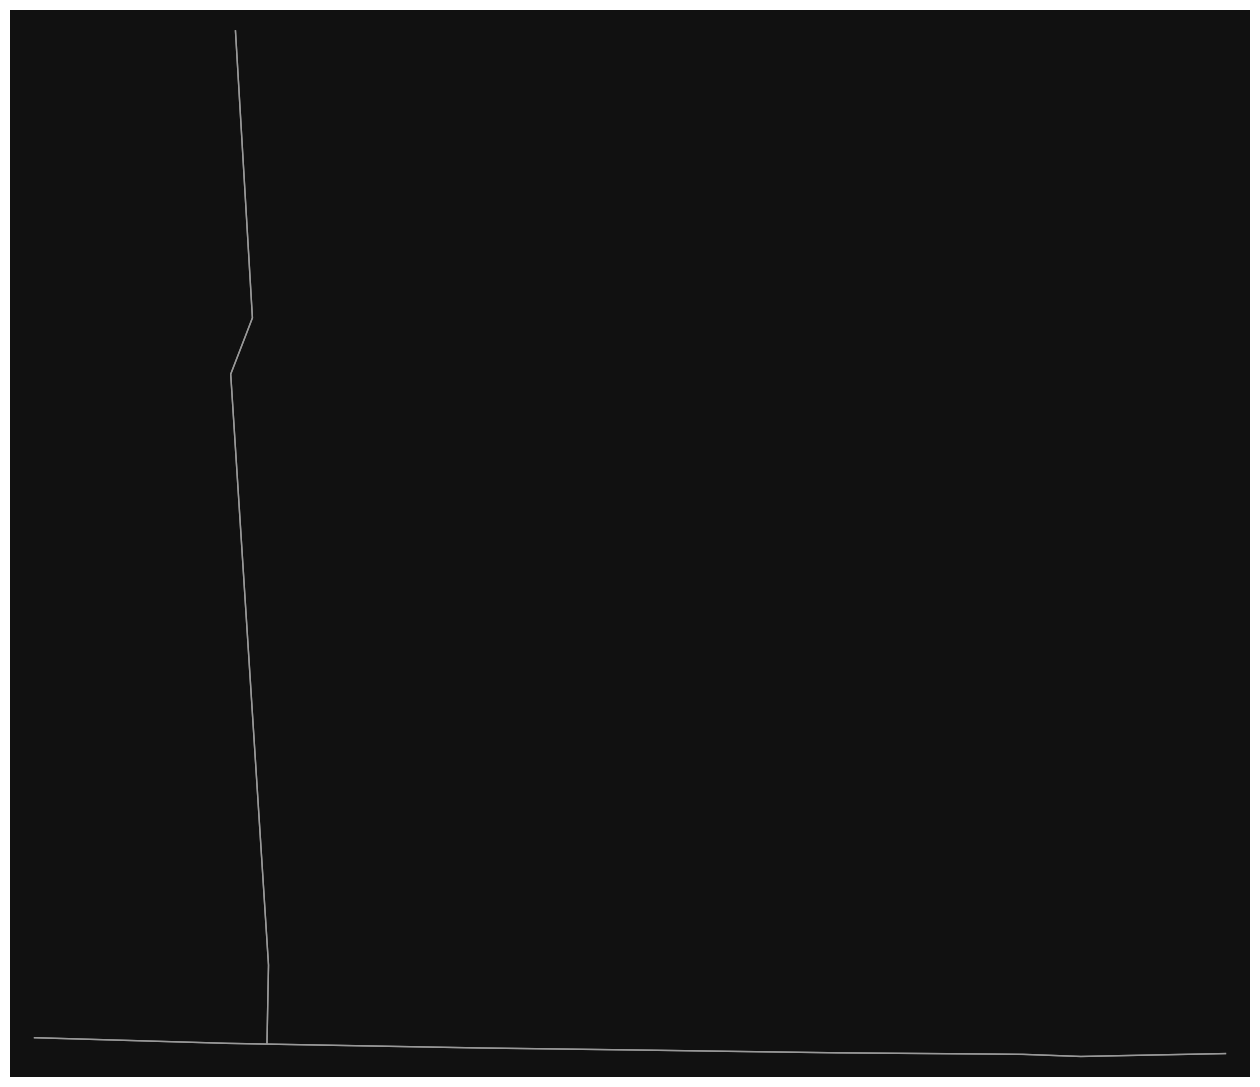

In [33]:
ox.plot_graph(G, figsize = (16,16),show=False,close=False)

In [47]:
# project all the candidate link 
point_proj = []
for i in range(len(candidate_link)):
    point_proj.append(point_matching(curr_loc, candidate_link.iloc[i]))
point_proj_df = pd.concat(point_proj)

In [175]:
point_proj_df['geometry'].iloc[2].x

819569.9610567739

In [193]:
# shortest path distance 
origin_point = (prev_loc['geometry'].iloc[0].x, prev_loc['geometry'].iloc[0].y)
target_point = (point_proj_df['geometry'].iloc[7].x, point_proj_df['geometry'].iloc[7].y)
print(ox.distance.nearest_nodes(G, origin_point[1], origin_point[0]))
print(ox.distance.nearest_nodes(G, target_point[1], target_point[0]))

135535395
135535395


In [198]:
candidate_link_uv
end_node.name

candidate_link_uv.loc[candidate_link_uv['u'] == end_node.name]

,u,v,key,osmid,lanes,ref,name,highway,maxspeed,oneway,reversed,length,geometry,width,access,lon_lat,str_id,prev_end_node
0,53200191,135535395,0,"[673214248, 234046511]",3,L 793,Wolbecker Straße,secondary,50,False,True,54.889,"LINESTRING (819585.705 5766245.100, 819590.522...",NaN,NaN,"LINESTRING (7.65181 51.95487, 7.65188 51.95486...","673214248,234046511",53200191
3,53200191,6152925224,0,470244584,3,L 793,Wolbecker Straße,secondary,50,False,False,36.973,"LINESTRING (819585.705 5766245.100, 819574.575...",NaN,NaN,"LINESTRING (7.65181 51.95487, 7.65165 51.95487...",470244584,53200191


In [199]:
candidate_link

,,,osmid,lanes,ref,name,highway,maxspeed,oneway,reversed,length,geometry,width,access,lon_lat,str_id,prev_end_node,perp_dist,connectivity,lon_lat_pair,edge_heading,heading_error
u,v,key,,,,,,,,,,,,,,,,,,,,
53200191,135535395,0,"[673214248, 234046511]",3,L 793,Wolbecker Straße,secondary,50,False,True,54.889,"LINESTRING (819585.705 5766245.100, 819590.522...",NaN,NaN,"LINESTRING (7.65181 51.95487, 7.65188 51.95486...","673214248,234046511",53200191,18.837131,1,"[(7.651807, 51.9548654), (7.6518768, 51.954862...",93.997786,182.002214
135535395,53200191,0,"[673214248, 234046511]",3,L 793,Wolbecker Straße,secondary,50,False,False,54.889,"LINESTRING (819640.807 5766244.782, 819631.704...",NaN,NaN,"LINESTRING (7.65261 51.95483, 7.65247 51.95483...","673214248,234046511",53200191,18.837131,0,"[(7.6526059, 51.9548309), (7.6524737, 51.95483...",273.998415,2.001585
6152925224,53200191,0,470244584,3,L 793,Wolbecker Straße,secondary,50,False,True,36.973,"LINESTRING (819548.588 5766245.690, 819569.082...",NaN,NaN,"LINESTRING (7.65127 51.95489, 7.65157 51.95488...",470244584,53200191,10.340390,0,"[(7.6512692, 51.954892), (7.6515661, 51.954876...",94.576660,181.423340
53200191,6152925224,0,470244584,3,L 793,Wolbecker Straße,secondary,50,False,False,36.973,"LINESTRING (819585.705 5766245.100, 819574.575...",NaN,NaN,"LINESTRING (7.65181 51.95487, 7.65165 51.95487...",470244584,53200191,10.340390,1,"[(7.651807, 51.9548654), (7.6516457, 51.954873...",274.577083,1.422917
53200192,6152925224,0,"[467653690, 673214250]",2,L 793,Wolbecker Straße,secondary,50,False,True,22.331,"LINESTRING (819526.175 5766246.307, 819544.832...",NaN,NaN,"LINESTRING (7.65094 51.95491, 7.65121 51.95489...","467653690,673214250",53200191,23.701631,0,"[(7.6509447, 51.9549104), (7.6512148, 51.95489...",95.243375,180.756625
6152925224,53200192,0,"[673214250, 467653690]",2,L 793,Wolbecker Straße,secondary,50,False,False,22.331,"LINESTRING (819548.588 5766245.690, 819544.832...",NaN,NaN,"LINESTRING (7.65127 51.95489, 7.65121 51.95489...","673214250,467653690",53200191,23.701631,0,"[(7.6512692, 51.954892), (7.6512148, 51.954894...",275.243631,0.756369
10548918654,6152925224,0,28961154,NaN,NaN,Brunostraße,residential,30,False,False,97.885,"LINESTRING (819545.555 5766343.170, 819547.189...",3,NaN,"LINESTRING (7.65132 51.95577, 7.65131 51.95552...",28961154,53200191,21.468604,0,"[(7.6513158, 51.9557673), (7.6513138, 51.95551...",181.884016,94.115984
6152925224,10548918654,0,28961154,NaN,NaN,Brunostraße,residential,30,False,True,97.885,"LINESTRING (819548.588 5766245.690, 819548.736...",3,NaN,"LINESTRING (7.65127 51.95489, 7.65128 51.95496...",28961154,53200191,21.468604,0,"[(7.6512692, 51.954892), (7.6512784, 51.954959...",1.883979,274.116021


In [126]:
ox.distance.shortest_path(G, orig, dest, weight='length', cpus=1)


NameError: name 'orig' is not defined

In [206]:
closest_node = candidate_node.loc[[ox.distance.nearest_nodes(G, origin_point[1], origin_point[0])]]
closest_edge = candidate_link.loc[[ox.distance.nearest_edges(G, curr_loc['geometry'].iloc[0].x, curr_loc['geometry'].iloc[0].y, return_dist=False)]]

In [161]:
fig, ax = ox.plot_graph(G)

# Visualizing SMP2 

In [207]:
%matplotlib tk
# This is how we  visualize edges and error bound 

# find the last two position for IMP
poly_1 = err_polygon(curr_loc, err_size)

# plotting edges and starting point together 
f, ax = plt.subplots()

# location for all point
#locs_utm.plot(ax=ax)
point_locs = gdf_utm['geometry'].to_frame()
point_locs.iloc[12:15].plot(ax = ax)

#err coord 
# better if we just take location at the last and use error bound function 
poly_1.plot(ax=ax, facecolor="none")

# this plot all the road system 
#edges_utm.plot(ax=ax)
candidate_link.iloc[[0]].plot(ax = ax, color = 'Red')
candidate_link.iloc[[3]].plot(ax = ax, color = 'Yellow')
candidate_link.iloc[4:6].plot(ax = ax, color = 'Blue')
candidate_link.iloc[6:8].plot(ax = ax)
# this plot the selected edge at time point 

# matched point plot
last_matched.plot(ax = ax, color = "Green")
point_proj_df.plot(ax = ax)
# plot closest node
closest_node.plot(ax = ax, color = "Black")
closest_edge.plot(ax = ax , color = "Black")

<Axes: >

In [107]:
point_proj_df['geometry'].iloc[[2]].x

0    819569.961057
dtype: float64